In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
import cv2
from PIL import Image
from skimage import morphology, io
from skimage.color import rgb2gray


def hough_circle(img,radius, threshold, supp, num):
    # img - binarny obrazok - hrany
    # radius - polomer hladanej kruznice
    # threshold - percentualne oznacenie thresholdu od maximalnej hodnoty accumulatora
    # supp - okolie vrcholu

    height, width = img.shape # rozmery vlozeneho obrazka
    image_edges = np.argwhere(img) # ulozenie suradnic hranovych bodov obrazka

    accumulator = np.zeros((height+2*radius,width+2*radius)) # inicializacia houghovo priestoru
    # priestor ma rozmery povodneho obrazka zvacsene o priemer hladanej kruznice - overflow problem
    # accumulator pre kruznicu je vo vseobecnosti trojrozmerny avsak ak pozname polomer hladanej
    # kruznice mozeme ho eliminovat do 2D


    # stredovy tvar rovnice kruznice je dany predpisom
    # (x - m)^2 + (y - n)^2 = r^2
    # respektive kruznicu mozeme vyjadrit parametricky
    # x = m + r * cos(theta)
    # y = n + r * sin(theta)
    # kde theta je z intervalu 0, 2*PI

    thetas = np.arange(0,360)*np.pi/180 # ziskanie intervalu theta
    circle = np.zeros((2*radius+1,2*radius+1)) # hladana kruznica

    for theta in thetas:
        x = int(np.round(radius*np.cos(theta))) # suradnice x bodov hladanej kruznice
        y = int(np.round(radius*np.sin(theta))) # suradnice y bodov hladanej kruznice
        circle[radius + x, radius + y] = 1 # znacenie hladanej kruznice

    # stred ziskanej kruznice budeme postupne ukladat na jednotlive suradnice hranovych bodov
    # cim budeme zapisovat hlasy do accumulatora
    for x,y in image_edges:
        X = [ x , x + 2 * radius]
        Y = [ y , y + 2 * radius]
        accumulator[X[0]:X[1],Y[0]:Y[1]] += circle[0:circle.shape[0]-1, 0:circle.shape[1]-1]

    #thresh = threshold*np.max(accumulator) # aplikovanie thresholdu na odfiltrovanie
    thresh = threshold * np.argwhere(circle).shape[0]/radius # aplikovanie thresholdu na odfiltrovanie

    accumulator = accumulator[radius:-radius, radius:-radius] # orezanie accumulatora na rozmery povodneho obrazku
    #plt.figure(figsize=(10,10))
    #plt.imshow(accumulator, cmap='gray')

    peaks = []
    continue_search = True

    while continue_search:
        value = np.max(accumulator)
        index = np.where(accumulator == value)
        idx = (index[0][0], index[1][0])

        if value > thresh:
            peaks.append(idx)

            # indexovanie cez houghov priestor
            x_min = idx[1] - supp
            if x_min < 0: x_min = 0
            x_max = idx[1] + supp
            if x_max > accumulator.shape[1]: x_max = accumulator.shape[1]

            y_min = idx[0] - supp
            if y_min < 0: y_min = 0
            y_max = idx[0] + supp
            if y_max > accumulator.shape[0]: y_max = accumulator.shape[0]

            accumulator[y_min:y_max, x_min:x_max] = 0
        else:
            continue_search = False


    if not peaks:
        return []
    elif len(peaks) < num:
        return peaks[0:len(peaks)]
    else:
        return peaks[0:num]


## Testovanie naprogramovanej Houghovej transformacie

<ipython-input-25-19e2b3a5e479>:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  circle = rgb2gray(circle_image)


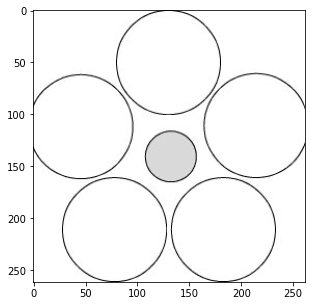

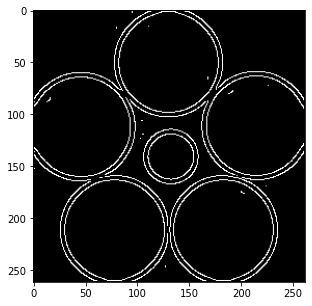

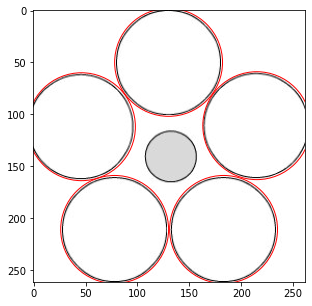

In [25]:
circle_image = io.imread('img2.jpg')
circle = rgb2gray(circle_image)
plt.figure(figsize=(5,5))
plt.imshow(circle, cmap='gray')

circle_edge = canny(circle, sigma=2.0, low_threshold=0.55, high_threshold=0.8)
plt.figure(figsize=(5,5))
plt.imshow(circle_edge, cmap='gray')
radius = 52

peaks = hough_circle(circle_edge,radius,1,10,5)
fig, ax = plt.subplots(figsize= (5, 5))
ax.imshow(circle_image, cmap = 'gray')
for peak in peaks:
    ax.add_artist(plt.Circle((peak[1],peak[0]), radius, fill= False, color= 'r'))

## Hladanie kraterov

Suradnice stredu 1. velkeho kratera a jeho polomer su:
heigth -> 12509 width -> 31307 radius -> 1738
----------------------------------
Suradnice stredu 1. maleho kratera a jeho polomer su:
heigth -> 12454 width -> 31490 radius -> 15
----------------------------------
Suradnice stredu 2. maleho kratera a jeho polomer su:
heigth -> 12651 width -> 31741 radius -> 15
----------------------------------
Suradnice stredu 3. maleho kratera a jeho polomer su:
heigth -> 12211 width -> 31498 radius -> 15
----------------------------------
Suradnice stredu 4. maleho kratera a jeho polomer su:
heigth -> 12364 width -> 31010 radius -> 15
----------------------------------
Suradnice stredu 5. maleho kratera a jeho polomer su:
heigth -> 12689 width -> 31350 radius -> 15
----------------------------------


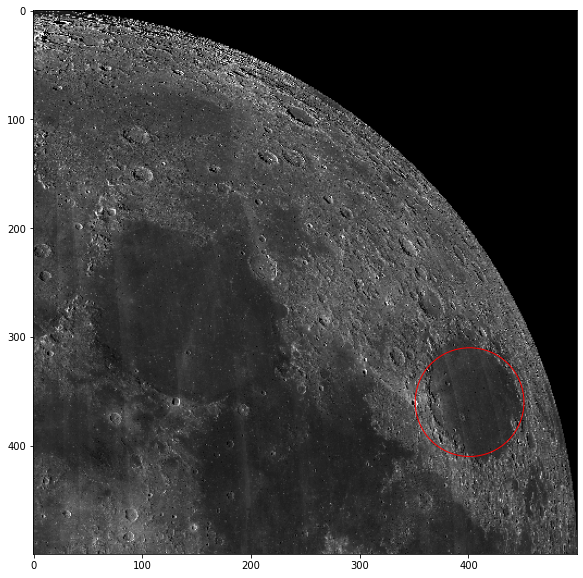

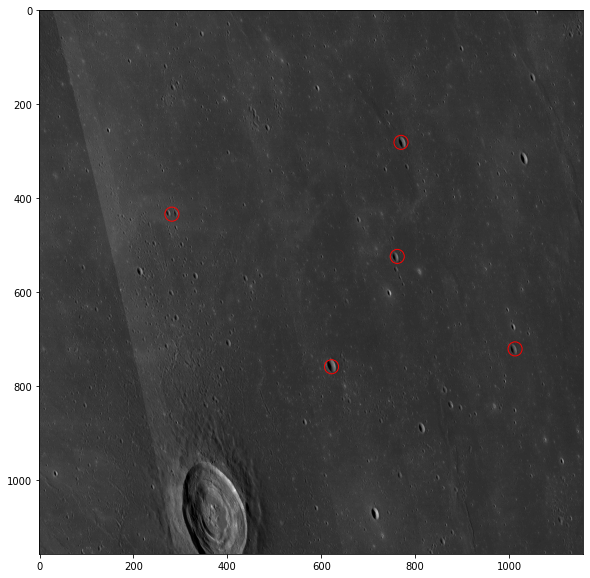

In [26]:
Image.MAX_IMAGE_PIXELS = None # zmena maximalnej velkosti obrazka
moon_image_tif = Image.open('moon.tif')
moon_image = np.array(moon_image_tif)


bins = 2 # pocet velkych vyrezov obrazka na jednu os

part_height = int(moon_image.shape[0]/bins)
part_width = int(moon_image.shape[1]/bins)

for i in range(0, moon_image.shape[0], part_height):
    for j in range(0, moon_image.shape[1], part_width):

        req_size = (500,500)

        temp = moon_image[i:i+part_height,j:j+part_width]
        temp = cv2.resize(temp, dsize=req_size)

        #predspracovanie obrazka (velmi specificke)
        image = canny(temp,sigma=2)
        image = morphology.dilation(image, morphology.disk(5))
        image = morphology.remove_small_objects(image>0, min_size=500)
        image = morphology.remove_small_holes(image>0, area_threshold=100)
        image = canny(image,sigma=1)

        #parametre pre funkciu houghovej transformacie
        radius = 1738
        threshold = 9
        supp = 30
        num = 1

        search = True

        peaks = hough_circle(image,int( radius * req_size[0] / part_height ),threshold,supp,num)

        if num >= len(peaks) > 0 and len(peaks) > 0:
            fig, ax = plt.subplots(figsize= (10, 10))
            ax.imshow(temp, cmap = 'gray')
            real_height = 0
            real_width = 0
            a = 0
            for peak in peaks:
                a += 1
                real_height = int(i + part_height / req_size[0] * peak[0])
                real_width = int(j + part_width / req_size[1] * peak[1])
                print("Suradnice stredu " +str(a)+". velkeho kratera a jeho polomer su:")
                print("heigth -> " + str(real_height) + " width -> " + str(real_width) + " radius -> " + str(radius))
                print("----------------------------------")
                ax.add_artist(plt.Circle((peak[1],peak[0]), int( radius * req_size[0] / part_height ), fill= False, color= 'r'))

                temp = moon_image[real_height - int(radius/3) : real_height + int(radius/3) , real_width - int(radius/3) : real_width + int(radius/3) ]



                #predspracovanie obrazka (velmi specificke)
                image = canny(temp,sigma=2)
                image = morphology.dilation(image, morphology.disk(5))
                image = morphology.remove_small_objects(image>0, min_size=500)
                image = morphology.remove_small_holes(image>0, area_threshold=100)
                image = canny(image,sigma=1)

                radius_small = 15
                threshold_small = 3
                supp_small = 50
                num_small = 5

                peaks_small = hough_circle(image, radius_small ,threshold_small, supp_small, num_small)
                if len(peaks_small) == num_small:
                    fig, ax = plt.subplots(figsize= (10, 10))
                    ax.imshow(temp, cmap = 'gray')
                    b = 0
                    for peak1 in peaks_small:
                        b += 1
                        real_height_small = real_height - int(radius/3)+ peak1[0]
                        real_width_small = real_width - int(radius/3)+ peak1[1]
                        print("Suradnice stredu " +str(b)+". maleho kratera a jeho polomer su:")
                        print("heigth -> " + str(real_height_small) + " width -> " + str(real_width_small)+ " radius -> "+ str(radius_small))
                        print("----------------------------------")
                        ax.add_artist(plt.Circle((peak1[1],peak1[0]), radius_small, fill= False, color= 'r'))
                    search = False

                else:
                    continue

            #break
        #else:
            #continue
    #break
    if not search:
        break
    else:
        continue